# Cobaya MCMC bf 

In [1]:
from classes_lkl_prof_functions import *
from MP_to_Cobaya_functions import *

In [2]:
test = lkl_prof('/home2/karwal/lkl_prof/test_ede_MP_workflow/', 'scf_f_z_scf1_cmb_bao_sne_', 'f_axion_ac')

test.prof_incr = 0.01
test.prof_max = 0.15
test.prof_min = 0.01
test.processes = 6

- Grab updated yaml file 

In [3]:
test.min_yaml = yaml_load_file(test.chains_dir+test.chain_file+'.updated.yaml')

### Get MP covmat

- Get MP chains covmat and Cobaya updated yaml
- For independent params, get covmat rows and columns
- Save file
- point lkl prof instance ("test") to this correct covmat file 

In [4]:
def use_MP_covmat(MP_covmat_file):
    try:
        np.loadtxt(test.chains_dir+test.chain_file+'.covmat')
        print('This function will not work as the file '+test.chains_dir+test.chain_file+'.covmat'+\
                ' already exists at this location. \nCobaya defaults to this file instead of any file'+\
                 ' passed through this function. ')
        return FileExistsError
    except OSError:
        cob_yaml_file = test.chains_dir + test.chain_file + '.updated.yaml'
        save_covmat_file = test.chains_dir +  'MP_to_cob.covmat'
        test.covmat_file = save_covmat_file
        return MP_covmat_to_cob(MP_covmat_file, cob_yaml_file, save_covmat_file)

In [5]:
MP_covmat_file = '/home2/karwal/lkl_prof/test_ede_MP_workflow/AxiCLASS_n3_MCMC_Planck_BAOfs_Pantheon_211210.covmat'
use_MP_covmat(MP_covmat_file)
test.min_yaml['sampler']['mcmc']['covmat'] = test.covmat_file

### Get best fit

Best fit can be set to several options:
- global minimizer run through Cobaya (which, why would we do that if this doesn't work great for EDE and takes long)
- global minimizer run through MP
- MAP of MCMC chains run through Cobaya 

#### MP bf

- Get MP chains bf
- Switch to Cobaya name convention
- Store as dictionary

In [6]:
MP_bf = get_MP_bf_dict('/home2/karwal/lkl_prof/test_ede_MP_workflow/AxiCLASS_n3_MCMC_Planck_BAOfs_Pantheon_211210.bestfit')
cob_bf = Cob_bf_from_MP(MP_bf)
cob_bf;

- Using bf file, update Cobaya indep params ref values in yaml

For now, just taking the global minimizer I had already run as starting point. But ideally, need to update this to 
- the bf of the previous MCMC run
- the MAP of each chain?? That might be harder 

In [7]:
ML_dict = deepcopy(cob_bf)

#### Cobaya MCMC chains bf

- Go through all the chains and find the best fit point
- Save the chain number and location of the bf point
- print the $-\log \mathcal{L}$ of the minimum found 
- Save point into dictionary

In [13]:
def find_MAP(processes = test.processes, chains_path = test.chains_dir+test.min_yaml['output']):
    min_found = 0.
    min_in_chain = 0
    for i in range(processes):
        mcmc_points = np.genfromtxt(chains_path+'.'+str(int(i+1))+'.txt')
        print("For chain {:d}, found minimum -logL = {:.2f}".format(i, min(mcmc_points[:,1])))
        if min_found:
            if min(mcmc_points[:,1])<min_found:
                min_found = min(mcmc_points[:,1])
                min_index = np.where(mcmc_points[:,1]==min(mcmc_points[:,1]))
                min_point = mcmc_points[min_index] 
                min_in_chain = str(int(i+1))
        else:
            min_found = min(mcmc_points[:,1])
            min_index = np.where(mcmc_points[:,1]==min(mcmc_points[:,1]))
            min_point = mcmc_points[min_index]
            min_in_chain = str(int(i+1))
    return min_found, min_in_chain, min_index, min_point

In [8]:
def get_MAP(processes = test.processes, chains_path = test.chains_dir+test.min_yaml['output']):
    min_found, min_in_chain, min_index, min_point = find_MAP(processes, chains_path)
    
    mcmc_header = read_header_as_list(chains_path+'.'+min_in_chain+'.txt')
    mcmc_min_line = np.genfromtxt(chains_path+'.'+min_in_chain+'.txt')[min_index][0]
    
    ML_dict = dict(zip(mcmc_header, mcmc_min_line))
    
    return ML_dict

In [ ]:
# ML_dict = get_MAP(number_of_chains, location_of_chains)

## MCMC minimizer 

### First iteration

Loop steps:
- Update ref values for params using this new bf dictionary
- Update sampler MH_factor, proposal and total steps wanted, as well as the output chain file 
- Dump new mcmc yaml 
- Run new mcmc yaml
- Get new bf from MCMC chains run

In [9]:
for param in test.min_yaml['params']:
    if param in ML_dict:
        if 'prior' in test.min_yaml['params'][param]:
            test.min_yaml['params'][param]['ref'] = ML_dict[param]

- Change MH accept factor 
- Change proposal scale
- Change max samples. **Note that this should be changed to total steps instead of accepted steps**
- Change output to filename with MH factor info 

In [10]:
test.min_yaml['sampler']['mcmc']['MH_accept_factor'] = 10 # 10, 200, 1000
test.min_yaml['sampler']['mcmc']['proposal_scale'] = 0.5 # 0.5, 0.1, 0.05
test.min_yaml['sampler']['mcmc']['max_samples'] = 200 # these need to be lowered such that 
                                                        # we take a total of 10k steps or so, 
                                                        # not 10k steps accepted 
                                                        # for MH_factor = 1, 10k steps ~ 3000 appected steps 

In [11]:
test.min_yaml['output'] = test.chain_file+'MH_'+str(test.min_yaml['sampler']['mcmc']['MH_accept_factor'])+'_'
test.min_yaml['sampler'];

- Dump this yaml into a file so we can run the MCMC 
- Run the MCMC

In [ ]:
with open(test.chains_dir + test.chain_file + '_mcmc_min.yaml', 'w') as yaml_file:
    dump(test.min_yaml, yaml_file, default_flow_style=False)

In [ ]:
os.chdir(test.chains_dir)
run("mpirun -np "+str(test.processes)+" cobaya-run "+test.chain_file+"_mcmc_min.yaml", shell=True)

### Second iteration 

- Go through all the chains and find the best fit point
- Save the chain number and location of the bf point
- print the $-\log \mathcal{L}$ of the minimum found 
- Save point into dictionary

In [20]:
ML_dict = get_MAP(processes = test.processes, chains_path = test.chains_dir+test.min_yaml['output'])
ML_dict;

For chain 0, found minimum -logL = 1927.99
For chain 1, found minimum -logL = 1927.80
For chain 2, found minimum -logL = 1927.70
For chain 3, found minimum -logL = 1928.44
For chain 4, found minimum -logL = 1928.12
For chain 5, found minimum -logL = 1928.26


In [18]:
print("After iteration of MH_factor = {:.0f} found minimum of -logLike = {:.3f}".format(test.min_yaml['sampler']['mcmc']['MH_accept_factor'],ML_dict['minuslogpost']))

After iteration of MH_factor = 10 found minimum of -logLike = 1927.702


#### Check $\chi^2$ convergence 

In [21]:
mcmc_chains = {}
for i in range(test.processes):
    mcmc_chains[str(i)] = np.loadtxt(test.chains_dir+test.min_yaml['output']+'.'+str(int(i+1))+'.txt', usecols=(1,))

(1927.0, 1930.0)

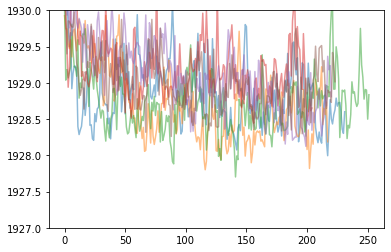

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(test.processes):
    plt.plot(mcmc_chains[str(i)], alpha=0.5)
plt.ylim([1927,1930])

Repeat above steps:
- Updated ref values for params using this new bf dictionary
- Update sampler MH_factor, proposal and total steps wanted, as well as the output chain file 
- Dump new mcmc yaml 
- Run new mcmc yaml

In [ ]:
for param in test.min_yaml['params']:
    if param in ML_dict:
        if 'prior' in test.min_yaml['params'][param]:
            test.min_yaml['params'][param]['ref'] = ML_dict[param]

In [ ]:
test.min_yaml['sampler']['mcmc']['MH_accept_factor'] = 200 # 10, 200, 1000
test.min_yaml['sampler']['mcmc']['proposal_scale'] = 0.1 # 0.5, 0.1, 0.05
test.min_yaml['sampler']['mcmc']['max_samples'] = 200 # these need to be lowered such that 
                                                        # we take a total of 10k steps or so, 
                                                        # not 10k steps accepted 
                                                        # for MH_factor = 1, 10k steps ~ 3000 appected steps 
test.min_yaml['output'] = test.chain_file+'MH_'+str(test.min_yaml['sampler']['mcmc']['MH_accept_factor'])+'_'
test.min_yaml['sampler'];

In [ ]:
with open(test.chains_dir + test.chain_file + '_mcmc_min.yaml', 'w') as yaml_file:
    dump(test.min_yaml, yaml_file, default_flow_style=False)

In [ ]:
os.chdir(test.chains_dir)
run("mpirun -np "+str(test.processes)+" cobaya-run "+test.chain_file+"_mcmc_min.yaml", shell=True)

### Third iteration

- Go through all the chains and find the best fit point
- Save the chain number and location of the bf point
- print the $-\log \mathcal{L}$ of the minimum found 
- Save point into dictionary

In [20]:
ML_dict = get_MAP(processes = test.processes, chains_path = test.chains_dir+test.min_yaml['output'])
ML_dict;

For chain 0, found minimum -logL = 1927.99
For chain 1, found minimum -logL = 1927.80
For chain 2, found minimum -logL = 1927.70
For chain 3, found minimum -logL = 1928.44
For chain 4, found minimum -logL = 1928.12
For chain 5, found minimum -logL = 1928.26


In [18]:
print("After iteration of MH_factor = {:.0f} found minimum of -logLike = {:.3f}".format(test.min_yaml['sampler']['mcmc']['MH_accept_factor'],ML_dict['minuslogpost']))

After iteration of MH_factor = 10 found minimum of -logLike = 1927.702


Repeat above steps:
- Updated ref values for params using this new bf dictionary
- Update sampler MH_factor, proposal and total steps wanted, as well as the output chain file 
- Dump new mcmc yaml 
- Run new mcmc yaml

In [ ]:
for param in test.min_yaml['params']:
    if param in ML_dict:
        if 'prior' in test.min_yaml['params'][param]:
            test.min_yaml['params'][param]['ref'] = ML_dict[param]

In [ ]:
test.min_yaml['sampler']['mcmc']['MH_accept_factor'] = 1000 # 10, 200, 1000
test.min_yaml['sampler']['mcmc']['proposal_scale'] = 0.05 # 0.5, 0.1, 0.05
test.min_yaml['sampler']['mcmc']['max_samples'] = 200 # these need to be lowered such that 
                                                        # we take a total of 10k steps or so, 
                                                        # not 10k steps accepted 
                                                        # for MH_factor = 1, 10k steps ~ 3000 appected steps 
test.min_yaml['output'] = test.chain_file+'MH_'+str(test.min_yaml['sampler']['mcmc']['MH_accept_factor'])+'_'
test.min_yaml['sampler'];

In [ ]:
with open(test.chains_dir + test.chain_file + '_mcmc_min.yaml', 'w') as yaml_file:
    dump(test.min_yaml, yaml_file, default_flow_style=False)

In [ ]:
os.chdir(test.chains_dir)
run("mpirun -np "+str(test.processes)+" cobaya-run "+test.chain_file+"_mcmc_min.yaml", shell=True)

### Final result

In [20]:
ML_dict = get_MAP(processes = test.processes, chains_path = test.chains_dir+test.min_yaml['output'])
ML_dict;

For chain 0, found minimum -logL = 1927.99
For chain 1, found minimum -logL = 1927.80
For chain 2, found minimum -logL = 1927.70
For chain 3, found minimum -logL = 1928.44
For chain 4, found minimum -logL = 1928.12
For chain 5, found minimum -logL = 1928.26


In [18]:
print("After iteration of MH_factor = {:.0f} found minimum of -logLike = {:.3f}".format(test.min_yaml['sampler']['mcmc']['MH_accept_factor'],ML_dict['minuslogpost']))

After iteration of MH_factor = 10 found minimum of -logLike = 1927.702


In [ ]:
print(ML_dict)